# Object Detection From Scratch - Part 3
by John Robinson 01/26/2023 [Follow @johnrobinsn on Twitter](https://twitter.com/johnrobinsn)

![jpeg](https://www.storminthecastle.com/img/03_compound_loss_files/friendly_robot_256.jpeg)

[<img src="https://www.storminthecastle.com/img/github.svg">](https://github.com/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/03_compound_loss.ipynb) [<img src="https://www.storminthecastle.com/img/colab.svg">](https://colab.research.google.com/github/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/03_compound_loss.ipynb)

This is **Part 3** of my series for building an intuition for how single-pass oject detectors such as YOLO and SSD work.  [Go to the Beginning](https://www.storminthecastle.com/posts/01_classification/)  

Brick by brick, I'll lay down a foundational understanding of how these models work. What I've covered so far:

* [Identify and Analyze a Suitable Dataset](https://www.storminthecastle.com/posts/01_classification/)
* [Build and Train a Model that can Classify the Largest Object in an Image](https://www.storminthecastle.com/posts/01_classification/)
* [Build and Train a Model that can Predict the Bounding Box of the Largest Object in an Image](https://www.storminthecastle.com/posts/02_bounding_box/)

Object detection considers the problem of building a model that can take an image and detect multiple objects within that image; predicting not only the object classes but also the bounding boxes of those objects within the image.  Single-pass detectors such as YOLO and SSD have solved this problem end-to-end performing the object detection task in a single forward inference pass of the model.  If what I'm describing is not clear, here is a fun video of [YOLO in action](https://www.youtube.com/watch?v=MPU2HistivI).

In this article, we'll continue to extend our model so that it can simultaneously predict the bounding box of the largest object and the classification label that goes along with it.  To do this we'll need to use a custom head and a compound loss function.

We're well on our way to building a single-pass object detector that can quickly detect multiple objects in an image.  Let's Go!

## Code From the Last Time
We can get started by pulling in some of the code that we covered from the [Part 1 notebook.](https://www.storminthecastle.com/posts/01_classification/)

In [1]:
from fastai.vision.all import *

import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects

SIZE=224

# display an image in such a way that we can layer on some additional annotations
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    show_image(im,ax) # We use this FastAI method to make life a little easier
    ax.set_xticks(np.linspace(0, SIZE, 8))
    ax.set_yticks(np.linspace(0, SIZE, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

# draw an outline around the shape; used to add contrast to the text so we can read it easily
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

# draw text in the specified location along with an outline so that there is some contrast between the text and the image
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

# generate a list of different colors for rendering our bounding boxes
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

# Grab our dataset
path = untar_data(URLs.PASCAL_2007)
imgs,lbl_bbox = get_annotations(path/'train.json')

# utility function that takes a bounding box in the form of x1,y1,x2,y2 and returns it's area (w*h)
def area(b): return (b[2]-b[0])*(b[3]-b[1])

# zip the bounding boxes together with the object class; sort it descending order by the size of the bounding; return the first one (largest one)
def get_largest(boxes):
    return sorted(L(zip(*boxes)),key=lambda b: -area(b[0]))[0]
    
# list comprehension to go through all of the training data and extract the largest objects
lrg_bbox = [get_largest(boxes) for boxes in lbl_bbox]
# Given the image file name and bounding box will scale the bounding box to 224x224
def squish_bbox(img_file,labeled_bbox):
    bbox,label = labeled_bbox
    p = path/f'train/{img_file}'
    img = Image.open(p)
    h,w = img.shape
    yscale,xscale = h/SIZE,w/SIZE
    scaled_bbox = (bbox[0]//xscale,bbox[1]//yscale,bbox[2]//xscale,bbox[3]//yscale)
    return [scaled_bbox,label]
    
lrg_bbox_scaled = [squish_bbox(img_file,labeled_bbox) for img_file,labeled_bbox in zip(imgs,lrg_bbox)]

# scale all of the bounding boxes in our 'largest' dataset using a list comprehension.
img2lrgbboxscaled = dict(zip(imgs,lrg_bbox_scaled))

Now we're set back up again with a "largest object dataset" along with our scaled bounding boxes.  Let's take a look at a sample from the dataset.

In [2]:
# look at a sample from our dictionary
k = L(img2lrgbboxscaled)[1]; k,img2lrgbboxscaled[k]

('000017.jpg', [(41.0, 47.0, 188.0, 206.0), 'horse'])

## Visualize Our Bounding Box

The model that we create in this notebook will be able to predict both the bounding box of the largest object in an image along with it's object class.  Let's look at a sample image from the dataset along with it's bounding box.

In [3]:
# Draw image with bounding box only
def show_lrg_item(im, lbl_bbox, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax = show_img(im, ax=ax)
    b = lbl_bbox[0]
    l = lbl_bbox[1]
    b = (*b[:2],b[2]-b[0]+1,b[3]-b[1]+1)
    draw_rect(ax, b, color=colr_list[0])
    draw_text(ax, b[:2], l, color=colr_list[0])

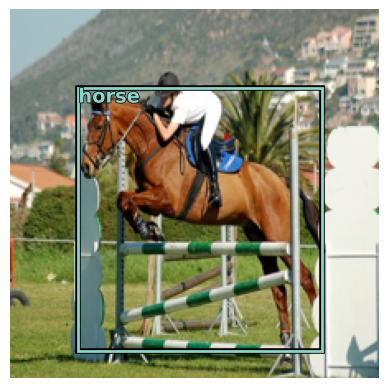

In [4]:
# Look at a sample from our dictionary

img_file = L(img2lrgbboxscaled)[1]
img_bbox_scaled = img2lrgbboxscaled[k]

img_scaled = Image.open(path/f'train/{img_file}').resize((SIZE,SIZE))

show_lrg_item(img_scaled,img_bbox_scaled)

## Training a Model that Predicts Multiple Things
We want to train a model that can predict both a bounding box and a class label.  So our model will need access to both of these labels during training and validation.

### Setting up the Dataloaders

We set up an array of getter functions (lambdas in this case).  All three of these take the image file name as input.  The first getter returns the full path to the image file.  The second getter returns a tensor containing the four bounding box coordinates of the largest object in the image.  The third getter returns the string class label for the largest object in the image.  The dictionary that we set up earlier makes this fairly easy.

In [5]:
# We grab both the bounding box of the sample and the class laabel
getters = [lambda o: path/'train'/o,lambda o: FloatTensor(img2lrgbboxscaled[o][0]),lambda o: img2lrgbboxscaled[o][1]]

In [6]:
# test to see if the getter works as expected
k,getters[0](k),getters[1](k),getters[2](k)

('000017.jpg',
 Path('/home/jr/.fastai/data/pascal_2007/train/000017.jpg'),
 tensor([ 41.,  47., 188., 206.]),
 'horse')

We'll still avoid performing any image augmentations for the sake of clarity in this article.

*Note: I'll show how to do image augmentations (batch transforms) in the next article.*

In [7]:
item_tfms = [Resize(SIZE, method='squish'),]
#batch_tfms = [Rotate(3), Flip(), Dihedral()]  # Some basic image augmentions so that that our model get's more input image diversity during training

Set up our datablock that we can use to create the data loaders. 

*Note: Now that we have more than two blocks, we have to specify n_inp=1 since we only have one input block with the others being output blocks.*

In [28]:
# note that we are using RegressionBlock with 4 activations since we want to predict four continuous
# numbers as well as a CategoryBlock since we want to predict a single category from our class labels.
dblock = DataBlock(blocks=(ImageBlock,RegressionBlock(n_out=4),CategoryBlock),
                 getters=getters,
                 item_tfms=item_tfms,
                 #batch_tfms=batch_tfms,
                 n_inp=1
                 )

In [9]:
dls = dblock.dataloaders(imgs, bs = 128)

Let's review the class labels from our dataset.

In [10]:
len(dls.vocab),dls.vocab

(20,
 ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'])

If we take a look at a sample batch, the groundtruth for the bounding box and the class label are displayed.

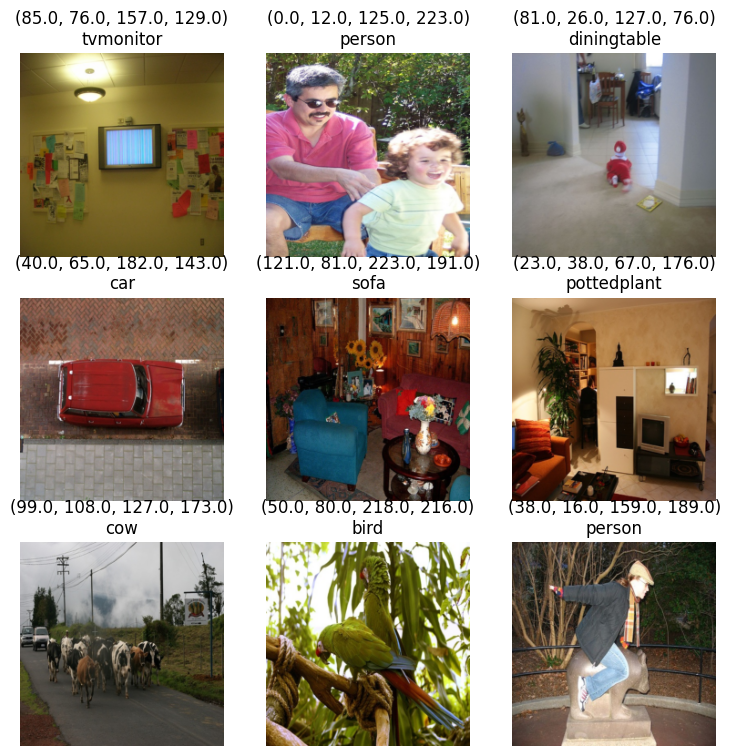

In [11]:
dls.show_batch()

FAI's show_batch method while quick and convenient doesn't let us visualize the bounding boxes.  Here is a custom show_batch function that provides a better visualization.

*Note: Fast AI really does have better visualization support for bounding boxes than this.  We'll find out how to enable them in the next article.*

In [29]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def show_batch(dls):
    b = dls.one_batch()
    #print(b[2])

    axs = subplots(3,3)[1].flat
    for img,box,c,ax in zip(b[0][:9],b[1][:9],b[2],axs):
        show_img(img,ax=ax)
        label = dls.vocab[c]
        draw_rect(ax,bb_hw(box.tolist()),color=colr_list[0])
        draw_text(ax,bb_hw(box.tolist())[:2],label,color=colr_list[0])

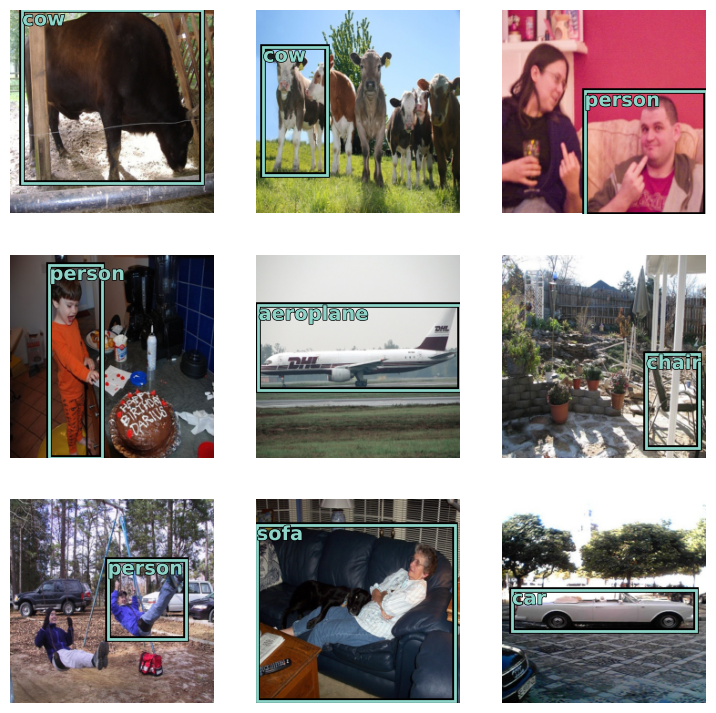

In [13]:
show_batch(dls)

As in previous articles, we'll continue to use the resnet34 architecture.  But we've exceeded the capabilities of the vision_learner API to infer a head that will work for our problem.  We'll need to define our own custom head.  Our head isn't any more complicated than the ones that we've seen before.  We just need to make sure sure it outputs the right number of activations, four for our bounding box and one for each of the 20 possible class labels.

In [27]:
# A custom head that outputs the right number of activations to predict both a bounding box and a class label for that bounding box.
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(dls.vocab)),
)

Since our model will be predicting both a bounding box and a class label, some of its output activations will be used to predict the bounding box and some of it's output activations will be used to predict the class label.  It's important to understand that it is the loss function, not the model architecture, that determines how these activations will be used.  Our loss function will have to treat the bounding box activations differently than the activations used for the class label prediction.  As we've seen in earlier articles, the bounding box prediction problem is a regression problem and we'll use l1_loss to measure the loss between the activation predictions and our bounding box groundtruth.  The class label prediction problem is a single label categorical prediction, so we'll use cross_entropy loss.  Since our loss function can only return a single value, we can just return the sum of these two loss terms.

*Note: Since the two different loss terms are on different scales and we don't want one to dominate over the other, we multiply the cross_entropy_loss term with a CROSS_ENTROPY_SCALE factor.  This will help to ensure that the terms are more equally weighted.  This is a hyperparameter that we can tune to get the best results.*

In [15]:
# Obtained this experimentally by training the model below for about ten epochs and comparing the two loss terms
CROSS_ENTROPY_SCALE = 20  

def detn_loss(input,bb_t,c_t):
    # separate out the activations for the bounding box prediction from the activations for the class label prediction
    bb_i,c_i = input[:, :4], input[:, 4:]
    # squash the bounding box activations to between 0 and 1 and scale up to range between 0 and 224 (SIZE).
    bb_i = F.sigmoid(bb_i)*SIZE
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return  F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*CROSS_ENTROPY_SCALE

In order to better illustrate how the loss function works during training, I've defined a few custom metrics so that we can see the average loss for each term during training.

In [16]:
# The bounding box loss term (l1_loss) in our compound loss function
def detn_l1(input, bb_t,c_t):
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(bb_i,bb_t).data

# The class label loss term (cross entropy loss) in our compound loss function
def detn_ce(input, bb_t,c_t):
    c_i = input[:, 4:]
    return F.cross_entropy(c_i, c_t).data

# Accuracy of our class label prediction
def detn_acc(input, bb_t,c_t):
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

Create the FAI learner using our custom head, compound loss function and our custom metrics.

In [17]:
learn = vision_learner(dls,resnet34,loss_func=detn_loss,custom_head=head_reg4,metrics=[detn_l1,detn_ce,detn_acc])

/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Let's take a look at our custom head now that it's been added to the model.  

*Note the last layer has the required 24 output activations.*

In [18]:
head = learn.model[1]
head

Sequential(
  (0): fastai.layers.Flatten(full=False)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=25088, out_features=256, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=24, bias=True)
)

### Train the Model

First let's find a reasonble learning rate.

/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


SuggestedLRs(valley=0.0010000000474974513)

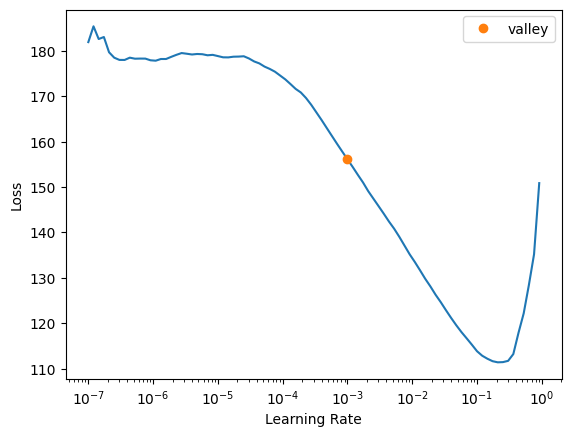

In [19]:
lrs = learn.lr_find()
lrs

In [20]:
lrs.valley

0.0010000000474974513

### Train Our Model
We'll fit the model to our training data using the selected loss function.  Here we're using the fine_tune method since we are using the resnet34 pretrained weights.

In [21]:
learn.fine_tune(20,base_lr=0.01)

epoch,train_loss,valid_loss,detn_l1,detn_ce,detn_acc,time
0,112.539139,75.526077,51.613968,1.195605,0.738000,00:05


epoch,train_loss,valid_loss,detn_l1,detn_ce,detn_acc,time
0,65.924217,69.782104,55.620678,0.708071,0.798000,00:07
1,55.345966,48.165241,33.149010,0.750812,0.794000,00:07
2,46.967365,45.886364,27.494341,0.919601,0.776000,00:07
3,40.714985,43.583378,28.086716,0.774833,0.788000,00:07
4,35.701904,40.572613,24.226746,0.817293,0.774000,00:07
5,31.866690,41.197239,23.212872,0.899218,0.772000,00:07
6,28.819010,42.126564,21.938875,1.009384,0.746000,00:07
7,26.302145,45.160389,21.854239,1.165308,0.730000,00:07
8,24.339399,45.256931,20.783333,1.223680,0.684000,00:06
9,22.228987,38.597343,19.823881,0.938673,0.750000,00:07


Now that we've trained the model, let's take a look at some predictions to see how it's doing.

In [22]:
# Some functions to visulize the predictions of our model.
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def show_preds(learner,valid=True):
    dl = learn.dls[1 if valid else 0].new(shuffle=True)
    imgs,boxes,labels = dl.one_batch()
    learner.model.eval()
    preds = learner.model(imgs)

    fig,axs = subplots(9,2)
    for img,box,label,pred,ax in zip(imgs,boxes,labels,preds,axs):
        img = (img-img.min())/(img.max()-img.min())
        bb_pred = F.sigmoid(pred[:4])*224
        cl_pred = pred[4:]
        cl_pred = cl_pred.argmax()
        show_img(img,ax=ax[0])
        draw_rect(ax[0],bb_hw(box.tolist()),color=colr_list[0])
        draw_text(ax[0],bb_hw(box.tolist())[:2],learner.dls.vocab[label],color=colr_list[0])
        show_img(img,ax=ax[1])
        draw_rect(ax[1],bb_hw(bb_pred.tolist()),color=colr_list[0])
        draw_text(ax[1],bb_hw(bb_pred.tolist())[:2],learner.dls.vocab[cl_pred],color=colr_list[0])
    fig.tight_layout()
    axs[0][0].set_title('label')
    axs[0][1].set_title('prediction')
    plt.show()

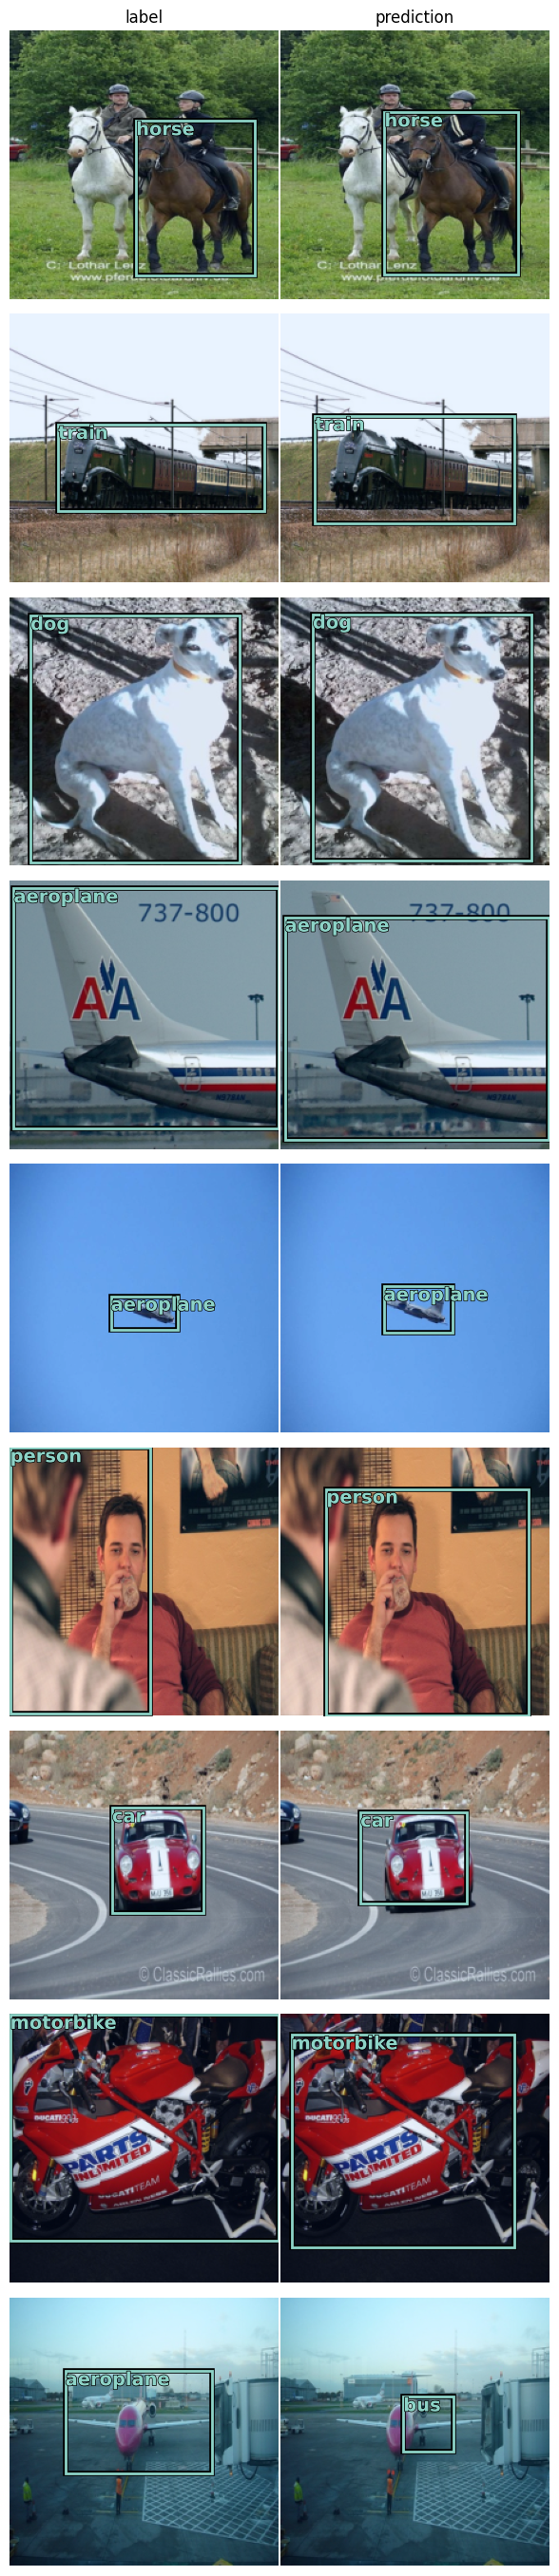

In [26]:
show_preds(learn)

The groundtruth bounding boxes from our training dataset are shown in the left-hand column and the predictions from the model are in the right-hand columnn.  This looks pretty good.  There is still a bit of confusion with the predicted bounding box enclosing more than more than one object of the same class.  We'll continue to make this better as we move to multiple object detection in a later article.

## Summary
In this article, we added the ability for our model to solve more than one problem at a time using a compound loss function.  We've used this custom loss function to train our network to predict both a bounding box and a class label, In coming articles, we'll build upon this idea to be able to predict multiple objects in an image.

In the next article, we'll look at how we can improve our training by adding back in batch image augmentations.

If you're enjoying this series, please like and retweet my content on Twitter, [@johnrobinsn](https://twitter.com/johnrobinsn)